In [ ]:
# This notebook records related code for analysing the microbial spectral dataset (n=81)
# Here is a diagram showing the relative paths of the input and output files and folders
# We provide compressed files in three folders: notebook, src, and msdb, at https://zenodo.org/records/17088906
# Most input and output files are included except for some very large files, exceeding 20 GB, like the pairwise similarity matrix of each in-silico library.
# Before using these codes, make sure to use them in the msanalyst folder cloned from git.
'''
MSanalyst/
    ├── notebook/
    ├── src/
    └── msdb/
        ├── GNPSLIBRARY/
        |   ├── ALL_GNPS_NO_PROPOGATED.mgf  (input)
        |   ├── GNPS-LIBRARY.mgf  (input)
        |   ├── edbMS1.csv  (output)
        |   ├── edb_info.json  (output)
        |   ├── GNPS-LIBRARY-INFO.json  (output)
        |   ├── GNPS-LIBRARY-INFO_new.json  (output)
        |   └── FS_edb_smi.json  (input)
        ├── GNPSLIBRARY_250514/
        |   └── ALL_GNPS_NO_PROPOGATED.mgf  (input)
        ├── COCONUT_2506/
        |   ├── coconut_csv_lite-06-2025.csv  (input)
        |   └── COCONUT.json  (output)
        ├── data/
        |   ├── hqtof/
        |   |   ├── idlist/
        |   |   |   └── H_qtof_non-redundant_CCMSIDs.npy  (output)
        |   |   └── FS_hqtof.json  (output)
        |   └── idlist/
        |       ├── NpclasstoSupplement.npy  (output)
        |       ├── NpclasstoSupplement.csv  (output)
        |       └── NpclasstoSupplement.json  (output)
        ├── FS_isdb_e0.json  (output)
        ├── FS_isdb_e1.json  (output)
        ├── FS_isdb_e2.json  (output)
        └── isdb_info.json  (input)
'''

# Import library

In [1]:
import sys, os,json,ujson,ms_entropy,matchms,json,spectral_entropy,time,pickle
sys.argv = ['jupyter']  # Clear the parameters passed to Jupyter
sys.path.append('../')
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import spectrum_utils.spectrum as sus
from itertools import zip_longest
from tqdm import tqdm, trange
from matplotlib import pyplot as plt
from collections import Counter,defaultdict
from my_packages import functions_new,ms2tools_new,cheminfo_tools,evaluation
from my_packages.peaktools import neutral_loss,modified_cosine,cosine
from rdkit import Chem
from FPSim2.io import create_db_file
from FPSim2 import FPSim2Engine
from spectral_entropy import similarity
from matchms import Spectrum
from spectral_entropy.spectral_entropy import calculate_entropy
from ms_entropy import FlashEntropySearch,FlashEntropySearchCore
from matchms.importing import load_from_json, load_from_mgf,load_from_msp, load_from_mzml, load_from_mzxml, load_from_usi
from sklearn.metrics import roc_curve,auc,confusion_matrix

Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail


# Load spectral libraries


### Experimental library

In [ ]:
# Preprocess
t = time.time()
FS_E_LIBRARY = functions_new.json_load('../msdb/FS_edb_info.json')
e_search = FlashEntropySearch()
FS_E_LIBRARY = e_search.build_index(FS_E_LIBRARY) # 635638 spectra
print(f'Finished in {(time.time() - t) / 60:.2f} min')

# Remove spectra without smiles
temp = [] # 594321 spectra remaining 
for SPEC in tqdm(FS_E_LIBRARY,total=len(FS_E_LIBRARY)):
    SMILE = SPEC['smile']
    if Chem.MolFromSmiles(SMILE):
        temp.append(SPEC)

# Save curated library as json file
for SPEC in tqdm(temp,total = len(temp)):
    PEAKS = SPEC['peaks'] 
    SPEC['peaks'] = PEAKS.tolist()

with open('../msdb/FS_edb_smi.json', "w") as f:
    json.dump(temp, f)

In [39]:
# 594321 spectra
# These spectra served as references in the library search
t = time.time()
temp = functions_new.json_load('../msdb/FS_edb_smi.json')
e_search = FlashEntropySearch()
FS_E_LIBRARY = e_search.build_index(temp)
print(f'Finished in {(time.time() - t) / 60:.2f} min')

Finished in 1.95 min


### In-silico library e0-e2

In [149]:
t = time.time()
FS_IS_LIBRARY_e0 = functions_new.json_load('../msdb/FS_isdb_e0.json')
is0_search = FlashEntropySearch()
FS_IS0_LIBRARY = is0_search.build_index(FS_IS_LIBRARY_e0)

FS_IS_LIBRARY_e1 = functions_new.json_load('../msdb/FS_isdb_e1.json')
is1_search = FlashEntropySearch()
FS_IS1_LIBRARY = is1_search.build_index(FS_IS_LIBRARY_e1)

FS_IS_LIBRARY_e2 = functions_new.json_load('../msdb/FS_isdb_e2.json')
is2_search = FlashEntropySearch()
FS_IS2_LIBRARY = is2_search.build_index(FS_IS_LIBRARY_e2)

print(f'Finished in {(time.time() - t) / 60:.2f} min')

Finished in 1.02 min


# Load query spectra (inputs)

## Dataset generation

In [3]:
# Load
# Acquared natively and has been upload to MSV000096272
STD_MGF = '../msdb/data/std/std.mgf' 
STD_CSV = '../msdb/data/std/std_info.csv' # [mz,intensities,metadata,metadata_harmonization]

# MSV000079758, can be downloaded at https://gnps.ucsd.edu//ProteoSAFe/status.jsp?task=ac7d5ce7603345b99fd252bc56185aa5
MSV_MGF = '../msdb/data/std/MSV000079758.mgf' 
MSV_TSV = '../msdb/data/std/MSV000079758.tsv' 

INPUT_MGF = STD_MGF
SPECTRA = functions_new.load_spectra_from_file(INPUT_MGF) # 'name', 'adduct', 'smiles'
SPECTRA_DF = pd.read_csv(STD_CSV,dtype={'name':str})

INPUT_MGF1 = MSV_MGF
SPECTRA1 = functions_new.load_spectra_from_file(INPUT_MGF1)
SPECTRA1_DF = pd.read_csv(MSV_TSV,sep='\t',dtype={'#Scan#':str}) # '#Scan#', 'Adduct', 'SpecMZ', 'Smiles'

In [4]:
# Merge STD and MSV000079758 data
FS_SPECTRA = []
for SPECTRUM in SPECTRA: #  STD data is collected natively and uploaded to MSV000096272.
    FID = SPECTRUM.metadata['feature_id']
    ADDUCT_TYPE = SPECTRA_DF[SPECTRA_DF['name'] == FID].adduct.values[0]
    if ADDUCT_TYPE == 'M+H':
        PM = SPECTRUM.metadata['precursor_mz']
        PEAKs = np.column_stack((SPECTRUM.mz,SPECTRUM.intensities))
        SMILE = SPECTRA_DF[SPECTRA_DF['name'] == FID].smiles.values[0]
        FS_SPECTRA.append(
            {
                "id": f'std{FID}',
                "precursor_mz": PM,
                "peaks": PEAKs,
                "smile": SMILE
            }
        )
        
for SPECTRUM in SPECTRA1: # MSV000079758 data
    FID = SPECTRUM.metadata['scans']
    try:
        ADDUCT_TYPE = SPECTRA1_DF[SPECTRA1_DF['#Scan#'] == FID].Adduct.values[0]
        if ADDUCT_TYPE == 'M+H':
            PM = SPECTRUM.metadata['precursor_mz']
            PEAKs = np.column_stack((SPECTRUM.mz,SPECTRUM.intensities))
            SMILE = SPECTRA1_DF[SPECTRA1_DF['#Scan#'] == FID].Smiles.values[0]
            FS_SPECTRA.append(
                {
                    "id": f'MSV{FID}',
                    "precursor_mz": PM,
                    "peaks": PEAKs,
                    "smile": SMILE
                }
            )
    except: pass

query = FlashEntropySearch()
# Pre-clean and sorted flash spectra (42 std + 39 MSV)
FS_SPECTRA = query.build_index(FS_SPECTRA) 

## Supplement with NPclassifier class

In [ ]:
# Get NPClassifier class from [API] (https://npclassifier.gnps2.org/classify?smiles=<smiles string>)
# 
query_list = list(range(len(FS_SPECTRA)))
while query_list:  
    idx = query_list[0]  # start from the first element
    FS_SPECTRUM = FS_SPECTRA[idx]
    SMILE = FS_SPECTRUM['smile']
    
    try:
        RES = cheminfo_tools.NPclass_request(SMILE)
        FS_SPECTRUM['superclass'] = RES['superclass_results']
        FS_SPECTRUM['pathway'] = RES['pathway_results']
        query_list.pop(0)  # del successfully queried id
    except Exception as e:
        print(f"Error processing index {idx} (SMILE: {SMILE}): {str(e)}")
        query_list.pop(0)
        query_list.append(idx)
        time.sleep(1)  

In [165]:
# Add class mannually from [website](https://npclassifier.ucsd.edu/)
FS_SPECTRA[27]['pathway'] = ['Terpenoids']
FS_SPECTRA[27]['superclass'] = ['Steroids'] 
FS_SPECTRA[78]['pathway'] = ['Carbohydrates']
FS_SPECTRA[78]['superclass'] = ['Nucleosides'] 

# Fail to predict class
FS_SPECTRA[72]['pathway'] = ['nan']
FS_SPECTRA[72]['superclass'] = ['nan'] 
FS_SPECTRA[77]['pathway'] = ['nan']
FS_SPECTRA[77]['superclass'] = ['nan'] 
FS_SPECTRA[80]['pathway'] = ['nan']
FS_SPECTRA[80]['superclass'] = ['nan'] 

## Supplement with entropy and number of peaks

In [156]:
# Add spectral properties
for FS_SPECTRUM in FS_SPECTRA:
    PEAKS = FS_SPECTRUM['peaks']
    entropy = calculate_entropy(PEAKS)
    Npeak = len(PEAKS)
    FS_SPECTRUM['entropy'] = entropy
    FS_SPECTRUM['num_peaks'] = Npeak

## Figure 2B Kde plot

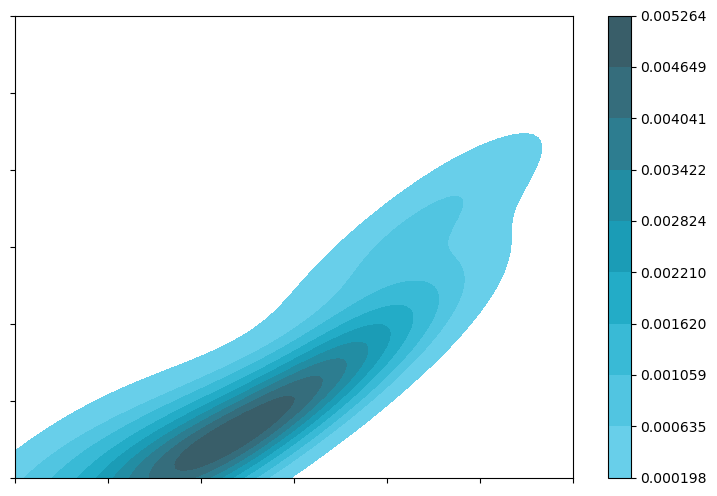

In [156]:
ENTROPY = [s['entropy'] for s in FS_SPECTRA]
NPEAK = [s['num_peaks'] for s in FS_SPECTRA]

width = 4.5
height = 3
plt.figure(figsize=(width*2 , height*2))
kde = sns.kdeplot(
    # data=i0_df,
    x=ENTROPY,
    y=NPEAK,
    fill=True,
    common_grid=True,
    common_norm=False,
    bw_adjust=1.5,
    # cut=0,
    cbar=True,
    legend=False,
    color = '#1999B2'
)
plt.ylim(-0, 300)
plt.xlim(0, 6)
# 设置刻度线，但不显示刻度值
plt.xticks(range(0, 7, 1), [''] * 7)  # x 轴刻度线，但刻度值为空
plt.yticks(range(0, 301, 50), [''] * 7)  # y 轴刻度线，但刻度值为空

plt.savefig('../msdb/data/pic/Fig2A.png',dpi=500, bbox_inches="tight")

# Library search
Search object: `FS_E_LIBRARY`,`FS_IS0_LIBRARY`,`FS_IS1_LIBRARY`,`FS_IS2_LIBRARY`

## Search against experimental library

In [8]:
# If the spectral pair shares at least one peak, it will be added to the compare_dict and improve computaional efficiency
t = time.time()
compare_dict = functions_new.get_compare_dict(FS_SPECTRA,FS_E_LIBRARY)
print(f'Finished in {(time.time() - t) / 60:.2f} min')

Finished in 1.32 min


In [10]:
G1,G2,G3 = evaluation.get_groups() # Get all the algorithms
ALGOs = G1 + G2 + G3

In [ ]:
# Search
t = time.time()
SEARCH_ALGOs = ['cosine']
for SEARCH_ALGO in tqdm(SEARCH_ALGOs,total=len(SEARCH_ALGOs)):
    EMS2_RESULT = {}
    # EMS2_SIM_MATRIX = np.empty((0, len(FS_E_LIBRARY))) # Initialize empty 
    EMS2_SIM_MATRIX  = np.full((len(FS_SPECTRA),len(FS_E_LIBRARY)), 0.0, dtype=float) 
    EMS2_MP_MATRIX =np.full((len(FS_SPECTRA),len(FS_E_LIBRARY)), 0, dtype=int)  
    
    for query_idx, E_idxs in tqdm(compare_dict.items(),total=len(compare_dict)):
        PM1 = FS_SPECTRA[query_idx]['precursor_mz']
        PEAKS1 = FS_SPECTRA[query_idx]['peaks']
        SPECTRUM1 = Spectrum(mz=np.array(PEAKS1[:, 0],dtype = float),
              intensities=np.array(PEAKS1[:, 1],dtype = float),
              metadata={"precursor_mz": PM1})
        
        for E_idx in E_idxs: # E_idxs
            PM2 = FS_E_LIBRARY[E_idx]['precursor_mz']
            PEAKS2 = FS_E_LIBRARY[E_idx]['peaks']
            SPECTRUM2 = Spectrum(mz=np.array(PEAKS2[:, 0],dtype = float),
              intensities=np.array(PEAKS2[:, 1],dtype = float),
              metadata={"precursor_mz": PM2})
            
            if functions_new.calculate_ppm(PM1,PM2) <= 10:
                SPEC_SIM, N_PEAK = functions_new.clac_spec_sim(PEAKS1,SPECTRUM1,PEAKS2,SPECTRUM2,SEARCH_ALGO)  
                EMS2_SIM_MATRIX[query_idx, E_idx] = SPEC_SIM  
                EMS2_MP_MATRIX[query_idx, E_idx] = N_PEAK

            
    np.save(f'../msdb/data/std/SearchMatrix/E_{SEARCH_ALGO}.npy',EMS2_SIM_MATRIX)
    np.save(f'../msdb/data/std/SearchMatrix/EMP_{SEARCH_ALGO}.npy',EMS2_MP_MATRIX)

print(f'Finished in {(time.time() - t) / 60:.2f} min')

## Against in-silico lib

In [74]:
# Get compare dictionary
IS0_compare_dict = functions_new.get_compar_dict(FS_SPECTRA,FS_IS0_LIBRARY) # {query_idx: [ref_idx1,ref_idx2,ref_idx2, ...]} 
IS1_compare_dict = functions_new.get_compar_dict(FS_SPECTRA,FS_IS1_LIBRARY)
IS2_compare_dict = functions_new.get_compar_dict(FS_SPECTRA,FS_IS2_LIBRARY)
print(f'Finished in {(time.time() - t) /60:.2f} min')

# Save as pickle file
with open('../msdb/data/std/IS0_compare_dict.pkl', 'wb') as f:
    pickle.dump(IS0_compare_dict, f)

with open('../msdb/data/std/IS1_compare_dict.pkl', 'wb') as f:
    pickle.dump(IS1_compare_dict, f)

with open('../msdb/data/std/IS2_compare_dict.pkl', 'wb') as f:
    pickle.dump(IS2_compare_dict, f)


100%|██████████████████████████████████████████| 81/81 [00:00<00:00, 922.75it/s]

Finished in 106.78 min


In [ ]:
t = time.time()
EL = 2 # 0,1,2
DIR = f'../msdb/data/std/'
LIB = {0:FS_IS0_LIBRARY,1:FS_IS1_LIBRARY,2:FS_IS2_LIBRARY}
# Load compare dict
with open(os.path.join(DIR,f'IS{EL}_compare_dict.pkl'), 'rb') as f:
    compare_dict = pickle.load(f)
FS_IS_LIBRARY = LIB[EL]
SEARCH_ALGOs = ['peak_percentage']

for SEARCH_ALGO in tqdm(SEARCH_ALGOs,total=len(SEARCH_ALGOs)):
    EMS2_RESULT = {}
    # EMS2_SIM_MATRIX = np.empty((0, len(FS_E_LIBRARY))) # Initialize empty 
    MS2_SIM_MATRIX  = np.full((len(FS_SPECTRA),len(FS_IS_LIBRARY)), 0.0, dtype=float) 
    MS2_MP_MATRIX =np.full((len(FS_SPECTRA),len(FS_IS_LIBRARY)), 0, dtype=int)  
    
    for query_idx, idxs in tqdm(compare_dict.items(),total=len(compare_dict)):
        PM1 = FS_SPECTRA[query_idx]['precursor_mz']
        PEAKS1 = FS_SPECTRA[query_idx]['peaks']
        SPECTRUM1 = Spectrum(mz=np.array(PEAKS1[:, 0],dtype = float),
              intensities=np.array(PEAKS1[:, 1],dtype = float),
              metadata={"precursor_mz": PM1})
        
        for idx in idxs: # E_idxs
            PM2 = FS_IS_LIBRARY[idx]['precursor_mz']
            PEAKS2 = FS_IS_LIBRARY[idx]['peaks']
            SPECTRUM2 = Spectrum(mz=np.array(PEAKS2[:, 0],dtype = float),
              intensities=np.array(PEAKS2[:, 1],dtype = float),
              metadata={"precursor_mz": PM2})
            
            if functions_new.calculate_ppm(PM1,PM2) <= 10:
                SPEC_SIM, N_PEAK = functions_new.clac_spec_sim(PEAKS1,SPECTRUM1,PEAKS2,SPECTRUM2,SEARCH_ALGO)  
                MS2_SIM_MATRIX[query_idx, idx] = SPEC_SIM  
                MS2_MP_MATRIX[query_idx, idx] = N_PEAK

            
    np.save(f'../msdb/data/std/SearchMatrix/IS{EL}_{SEARCH_ALGO}.npy',MS2_SIM_MATRIX)
    np.save(f'../msdb/data/std/SearchMatrix/IS{EL}_{SEARCH_ALGO}_MP.npy',MS2_MP_MATRIX)

# print(f'Finished in {(time.time() - t) / 60:.2f} min')

## Chemical similarity
### Experimental

In [97]:
# Create FP database
DIR = '../msdb/data/std/'
IDX2SMILE = [[s['smile'],idx] for idx,s in enumerate(FS_E_LIBRARY)]
FPDB_FILE = os.path.join(DIR,'chem/Esearch_fp_db.h5')
if not os.path.exists(FPDB_FILE):
    create_db_file(
        mols_source=IDX2SMILE, 
        filename=FPDB_FILE,
        mol_format='smiles', # required
        fp_type='Morgan',
        fp_params={'radius': 2, 'fpSize': 1024}
    )

In [98]:
# FP_SPECTRA search against FS_E_LIB
fpe = FPSim2Engine(fp_filename=FPDB_FILE)
hit_dict = {}
for idx in trange(len(FS_SPECTRA)):
    try:
        SMILE = FS_SPECTRA[idx]['smile']
        results = fpe.similarity(SMILE, threshold=0.35, metric='dice', n_workers=1)  # [(LIBidx,similarity1),(),...]
        results = [x for x in results if x[0] != idx] # Remove self comparison
        fpidx_list = [x[0] for x in results]
        fpsim_list = [x[1] for x in results]

        if fpidx_list:
            hit_dict[idx] = {'idx': fpidx_list, 'sim_list': fpsim_list}  # {LIBidx: {},{},..}
    except:print(idx)
    

100%|███████████████████████████████████████████| 81/81 [00:06<00:00, 11.75it/s]


In [99]:
ECHEM_MATRIX  = np.full((len(FS_SPECTRA),len(FS_E_LIBRARY)), 0.0, dtype=float) 

for key, value in hit_dict.items():
    QueryIdx = key
    MatchIdxs = value['idx']
    MatchSim = value['sim_list']
    for idx, MatchIdx in enumerate(MatchIdxs):
        ECHEM_MATRIX[QueryIdx,MatchIdx] = MatchSim[idx]

In [100]:
'''
Save results
'''
np.save(os.path.join(DIR,f'SearchMatrix/EChemSim.npy'),ECHEM_MATRIX)

### In-silico

In [111]:
# Create FP database
IDX2SMILE_IS0 = [[SPEC['smile'],idx] for idx, SPEC in enumerate(FS_IS0_LIBRARY)]
IDX2SMILE_IS1 = [[SPEC['smile'],idx] for idx, SPEC in enumerate(FS_IS1_LIBRARY)]
IDX2SMILE_IS2 = [[SPEC['smile'],idx] for idx, SPEC in enumerate(FS_IS2_LIBRARY)]

FPDB0 = f'../msdb/data/std/chem/is0_fp_db.h5'
if not os.path.exists(FPDB0):
    create_db_file(
        mols_source=IDX2SMILE_IS0,
        filename=FPDB0,
        mol_format='smiles',  # required
        fp_type='Morgan',
        fp_params={'radius': 2, 'fpSize': 1024}
    )

FPDB1 = f'../msdb/data/std/chem/is1_fp_db.h5'
if not os.path.exists(FPDB1):
    create_db_file(
        mols_source=IDX2SMILE_IS1,
        filename=FPDB1,
        mol_format='smiles',  # required
        fp_type='Morgan',
        fp_params={'radius': 2, 'fpSize': 1024}
    )

FPDB2 = f'../msdb/data/std/chem/is2_fp_db.h5'
if not os.path.exists(FPDB2):
    create_db_file(
        mols_source=IDX2SMILE_IS2,
        filename=FPDB2,
        mol_format='smiles',  # required
        fp_type='Morgan',
        fp_params={'radius': 2, 'fpSize': 1024}
    )

In [112]:
# Search 
fpe0 = FPSim2Engine(fp_filename=FPDB0)
fpe1 = FPSim2Engine(fp_filename=FPDB1)
fpe2 = FPSim2Engine(fp_filename=FPDB2)
hit_dict0,hit_dict1,hit_dict2 = {},{},{}
for idx in trange(len(FS_SPECTRA)):
    SMILE = FS_SPECTRA[idx]['smile']
    results0 = fpe0.similarity(SMILE, threshold=0.35, metric='dice', n_workers=1)  # [(LIBidx,similarity1),(),...]
    results0 = [x for x in results0 if x[0] != idx] # Remove self comparison
    fpidx_list0 = [x[0] for x in results0]
    fpsim_list0 = [x[1] for x in results0]

    results1 = fpe1.similarity(SMILE, threshold=0.35, metric='dice', n_workers=1)  # [(LIBidx,similarity1),(),...]
    results1 = [x for x in results1 if x[0] != idx] # Remove self comparison
    fpidx_list1 = [x[0] for x in results1]
    fpsim_list1 = [x[1] for x in results1]

    results2 = fpe1.similarity(SMILE, threshold=0.35, metric='dice', n_workers=1)  # [(LIBidx,similarity1),(),...]
    results2 = [x for x in results2 if x[0] != idx] # Remove self comparison
    fpidx_list2 = [x[0] for x in results2]
    fpsim_list2 = [x[1] for x in results2]

    if fpidx_list0:
        hit_dict0[idx] = {'idx': fpidx_list0, 'sim_list': fpsim_list0}  # {LIBidx: {},{},..}
    if fpidx_list1:
        hit_dict1[idx] = {'idx': fpidx_list1, 'sim_list': fpsim_list1}  # {LIBidx: {},{},..}
    if fpidx_list2:
        hit_dict2[idx] = {'idx': fpidx_list2, 'sim_list': fpsim_list2}  # {LIBidx: {},{},..}



100%|███████████████████████████████████████████| 81/81 [00:16<00:00,  5.03it/s]


In [113]:
IS0_CHEM_MATRIX  = np.full((len(FS_SPECTRA),len(FS_IS0_LIBRARY)), 0.0, dtype=float) 
IS1_CHEM_MATRIX  = np.full((len(FS_SPECTRA),len(FS_IS1_LIBRARY)), 0.0, dtype=float) 
IS2_CHEM_MATRIX  = np.full((len(FS_SPECTRA),len(FS_IS2_LIBRARY)), 0.0, dtype=float) 

for key, value in hit_dict0.items():
    QueryIdx = key
    MatchIdxs = value['idx']
    MatchSim = value['sim_list']
    for idx, MatchIdx in enumerate(MatchIdxs):
        IS0_CHEM_MATRIX[QueryIdx,MatchIdx] = MatchSim[idx]

for key, value in hit_dict1.items():
    QueryIdx = key
    MatchIdxs = value['idx']
    MatchSim = value['sim_list']
    for idx, MatchIdx in enumerate(MatchIdxs):
        IS1_CHEM_MATRIX[QueryIdx,MatchIdx] = MatchSim[idx]

for key, value in hit_dict2.items():
    QueryIdx = key
    MatchIdxs = value['idx']
    MatchSim = value['sim_list']
    for idx, MatchIdx in enumerate(MatchIdxs):
        IS2_CHEM_MATRIX[QueryIdx,MatchIdx] = MatchSim[idx]

# Save results
DIR = '../msdb/data/std/chem/'
np.save(os.path.join(DIR,f'IS0_ChemSim.npy'),IS0_CHEM_MATRIX)
np.save(os.path.join(DIR,f'IS1_ChemSim.npy'),IS1_CHEM_MATRIX)
np.save(os.path.join(DIR,f'IS2_ChemSim.npy'),IS2_CHEM_MATRIX)

## Evaluation

### Confusion matrix

#### Experimental
##### Figure 2C Data S1 and Figure S3-S5

In [24]:
optimal_threshold = {}  # dict to record the optimal threshold for each algorithms
DIR = '../msdb/data/std/'

In [32]:
# Load search matrix
G1,G2,G3 = evaluation.get_groups() # Load algorithms
SEARCH_ALGORITHMs = G1+G2+G3
SHARED_PEAKs = False # True and false for with and without restriction of matched peaks
# SEARCH_ALGORITHMs = ['symmetric_chi_squared']

EM_RES,TP_RES,TP_RES_NAMES = [],[],[]
for ALGO in tqdm(SEARCH_ALGORITHMs,total = len(SEARCH_ALGORITHMs)):
    # Load Spec search matrices:
    ESPEC_MATRIX = np.load(os.path.join(DIR,f'SearchMatrix/E_{ALGO}.npy')) # spectral sim matrix
    EMP_MATRIX = np.load(os.path.join(DIR,f'SearchMatrix/EMP.npy')) # matched_ion matrix
    ECHEM_MATRIX = np.load(os.path.join(DIR,f'SearchMatrix/EChemSim.npy')) # chemical sim matrix
    
    if SHARED_PEAKs:
        EMIDXs = np.full(ESPEC_MATRIX.shape[0], 0, dtype=int)   
        EMaxSpecSim  = np.full(ESPEC_MATRIX.shape[0], 0.0, dtype=float) 
        EMaxChemSim = np.full(ESPEC_MATRIX.shape[0], 0.0, dtype=float)
        
        for idx,EMP_ARR in enumerate(EMP_MATRIX):
            cols = np.where(EMP_ARR >=6)[0] # <tuple> Min matched peaks >= 5
            if cols.any(): # 
                FilColIdx = np.argmax(ESPEC_MATRIX[idx, cols])
                best_col = cols[FilColIdx]
                EMIDXs[idx] = best_col
                EMaxSpecSim[idx]  =  ESPEC_MATRIX[idx, best_col]
                EMaxChemSim[idx] = ECHEM_MATRIX[idx, best_col]
        ELables = [1 if x >= 0.75 else 0 for x in EMaxChemSim] # Dice sim ≥ 0.75 is considered true positive prediction
        
        THRESHOLDs =  [optimal_threshold[ALGO]] # np.arange(0, 1.01, 0.005) # or [0.7]
        FPRs, TPRs, FDRs, TNs, FPs, FNs, TPs = [],[],[],[],[],[],[]
        for THRESHOLD in THRESHOLDs:
            Y_PREDCTIONs = [1 if x >= THRESHOLD else 0 for x in EMaxSpecSim] # Spectral sim ≥ threholds is considered as 1 
            TN, FP, FN, TP  = confusion_matrix(ELables, Y_PREDCTIONs).ravel()
            TNs.append(TN)
            FPs.append(FP)
            FNs.append(FN)
            TPs.append(TP)
            FPRs.append(FP/(FP+TN+ 1e-12))
            TPRs.append(TP/(TP+FN+ 1e-12))
            FDRs.append(FP/(FP+TP+ 1e-12))
        J = np.array([TPRs[idx]-FPRs[idx] for idx in range(len(FPRs))]) # # Youden's J to find the optimal threshold
        optimal_idx = np.argmax(J)
        OT = THRESHOLDs[optimal_idx]
        TN, FP, FN, TP = TNs[optimal_idx], FPs[optimal_idx], FNs[optimal_idx], TPs[optimal_idx]
        FDR,TPR,FPR = FPRs[optimal_idx],TPRs[optimal_idx],FPRs[optimal_idx]

        
    else:
        # EMaxIdx = []
    
        EMaxIdx = [np.argmax(arr) for arr in ESPEC_MATRIX] # Top1 spectral scoring
        EMaxSpecSim = [ESPEC_MATRIX[idx][EMaxIdx[idx]] for idx in range(len(EMaxIdx))] # Spectral similarity with top 1 match
        EMaxChemSim = [ECHEM_MATRIX[idx][EMaxIdx[idx]] for idx in range(len(EMaxIdx))] # Chemical dice simialrity with top 1 match
        ELables = [1 if x >= 0.75 else 0 for x in EMaxChemSim] 

        # *****************************************************
        # Switched between [0.7] and np.arange(0, 1.01, 0.001) 
        # *****************************************************
        THRESHOLDs = np.arange(0, 1.01, 0.001) 
        FPRs, TPRs, FDRs, TNs, FPs, FNs, TPs, TPRatios,FNRatios = [],[],[],[],[],[],[],[],[]
        for THRESHOLD in THRESHOLDs:
            Y_PREDCTIONs = [1 if x >= THRESHOLD else 0 for x in EMaxSpecSim] # Spectral sim ≥ threholds is considered as 1 
            TN, FP, FN, TP  = confusion_matrix(ELables, Y_PREDCTIONs).ravel()
            TPRatio = TP/81
            FNRatio = FN/81
            TPRatios.append(TPRatio)
            FNRatios.append(FNRatio)
            TNs.append(TN)
            FPs.append(FP)
            FNs.append(FN)
            TPs.append(TP)
            FPRs.append(FP/(FP+TN+ 1e-12))
            TPRs.append(TP/(TP+FN+ 1e-12))
            FDRs.append(FP/(FP+TP+ 1e-12))

        # Save the confusion matrix of each threshold for the line chart
        # Figure S3-S5
        DF = pd.DataFrame({'Threshold':THRESHOLDs,
                           f'TP proportion':TPRatios,
                           f'FDR':FDRs,
                           f'FPR':FPRs,f'TPR':TPRs,
                           f'FN proportion':FNRatios
                           })
        DF.to_csv(os.path.join(DIR,f'CMcsv/{ALGO}.csv'),index=None)
        

        # Summarize the indicators of confusion matrix
        J = np.array([TPRs[idx]-FPRs[idx] for idx in range(len(FPRs))]) # # Youden's J to find the optimal threshold
        optimal_idx = np.argmax(J)
        OT = THRESHOLDs[optimal_idx]
        optimal_threshold[ALGO] = OT # Record optimal threshold for each algorithm
        

        TN, FP, FN, TP = TNs[optimal_idx], FPs[optimal_idx], FNs[optimal_idx], TPs[optimal_idx]
        FDR,TPR,FPR = FPRs[optimal_idx],TPRs[optimal_idx],FPRs[optimal_idx]
        
        # TPs = [idx for idx in range(len(ELables)) if Y_PREDCTIONs[idx] == ELables[idx] == 1]

        
    EM_RES.append({'library':'experimental',
                   'spectral_algorithm':ALGO,
                   'optimal_threshold': OT,
                    'TN':TN,'FP':FP,'FN':FN,'TP':TP,
                   'FDR':FDR,'TPR':TPR,'FPR':FPR,
                    # 'AUC':AUC
                   })
    
    TP_RES_NAMES.append(ALGO)
    TP_RES.append(TPs)


100%|███████████████████████████████████████████| 46/46 [00:38<00:00,  1.20it/s]


In [ ]:
# Convert to dataframe and save
EM_DF = pd.DataFrame(EM_RES).sort_values(by='TP', ascending=False)
EM_DF.to_csv('../msdb/data/std/E_search_algorithms.csv')
EM_DF

#### In-silico

In [174]:
EL = 0
DIR = '../msdb/data/std/'
IS_SIM_MATRIX = np.load(os.path.join(DIR,f'SearchMatrix/IS{EL}_entropy.npy'))
IS_MP_MATRIX = np.load(os.path.join(DIR,f'SearchMatrix/IS{EL}_entropy_MP.npy'))
ISCHEM_MATRIX = np.load(os.path.join(DIR,f'chem/IS{EL}_ChemSim.npy'))

In [ ]:
# Load search matrix
# THRESHOLDs = list(np.arange(0, 1.1, 0.001))
# peak_threshold = list(np.arange(1,11,1))
# *****************************************************
EL = 2 # Switch between 0, 1, 2
# *****************************************************
DIR = '../msdb/data/std/'
SHARED_PEAKs = False
SEARCH_ALGORITHMs = ['entropy','modified_cosine','peak_percentage']

ISM_RES,TP_RES,TP_RES_NAMES = [],[],[]
for ALGO in tqdm(SEARCH_ALGORITHMs,total = len(SEARCH_ALGORITHMs)):
    # Load Spec search matrices:
    # try:
        ESPEC_MATRIX = np.load(os.path.join(DIR,f'SearchMatrix/IS{EL}_{ALGO}.npy')) # spectral sim matrix
        EMP_MATRIX = np.load(os.path.join(DIR,f'SearchMatrix/IS{EL}_{ALGO}_MP.npy')) # matched_ion matrix
        ECHEM_MATRIX = np.load(os.path.join(DIR,f'chem/IS{EL}_ChemSim.npy')) # chemical sim matrix
        
        if SHARED_PEAKs:
            EMIDXs = np.full(ESPEC_MATRIX.shape[0], 0, dtype=int)   
            EMaxSpecSim  = np.full(ESPEC_MATRIX.shape[0], 0.0, dtype=float) 
            EMaxChemSim = np.full(ESPEC_MATRIX.shape[0], 0.0, dtype=float)
            
            for idx,EMP_ARR in enumerate(EMP_MATRIX):
                cols = np.where(EMP_ARR >=6)[0] # <tuple> Min matched peaks >= 5
                if cols.any(): # 
                    FilColIdx = np.argmax(ESPEC_MATRIX[idx, cols])
                    best_col = cols[FilColIdx]
                    EMIDXs[idx] = best_col
                    EMaxSpecSim[idx]  =  ESPEC_MATRIX[idx, best_col]
                    EMaxChemSim[idx] = ECHEM_MATRIX[idx, best_col]
            ELables = [1 if x >= 0.75 else 0 for x in EMaxChemSim] # Chem sim ≥ 0.75 is considered true positive
            
            # ROC_AUC curve
            FPRs, TPRs, THRESHOLDs = roc_curve(ELables, EMaxSpecSim)
            AUC = auc(FPRs,TPRs)
            # J = TPRs - FPRs # # Youden's J to find the optimal threshold
            # optimal_idx = np.argmax(J)
            OT = optimal_threshold[ALGO] # optimal spectral similarity threshold 
            Y_PREDCTIONs = [1 if x >= OT else 0 for x in EMaxSpecSim] # Spectral sim ≥ threholds is considered as 1 
            TN, FP, FN, TP  = confusion_matrix(ELables, Y_PREDCTIONs).ravel()
            FDR = FP/(FP+TP) 

            
        else:
            # EMaxIdx = []
            
            EMaxIdx = [np.argmax(arr) for arr in ESPEC_MATRIX] # Top1 spectral scoring
            EMaxSpecSim = [ESPEC_MATRIX[idx][EMaxIdx[idx]] for idx in range(len(EMaxIdx))] # Spectral similarity with top 1 match
            EMaxChemSim = [ECHEM_MATRIX[idx][EMaxIdx[idx]] for idx in range(len(EMaxIdx))] # Chemical dice simialrity with top 1 match
            ELables = [1 if x >= 0.75 else 0 for x in EMaxChemSim] 
        
            # # ROC_AUC curve
            # FPRs, TPRs, THRESHOLDs = roc_curve(ELables, EMaxSpecSim)
            # AUC = auc(FPRs,TPRs) 
            # J = TPRs - FPRs # # Youden's J to find the optimal threshold
            # optimal_idx = np.argmax(J)
            # OT = THRESHOLDs[optimal_idx] # optimal spectral similarity threshold 
        
            THRESHOLDs = np.arange(0, 1.01, 0.001)
            FPRs, TPRs, FDRs, TNs, FPs, FNs, TPs, TPRatios,FNRatios = [],[],[],[],[],[],[],[],[]
            for THRESHOLD in THRESHOLDs:
                Y_PREDCTIONs = [1 if x >= THRESHOLD else 0 for x in EMaxSpecSim] # Spectral sim ≥ threholds is considered as 1 
                TN, FP, FN, TP  = confusion_matrix(ELables, Y_PREDCTIONs).ravel()
                TPRatio = TP/81
                FNRatio = FN/81
                TPRatios.append(TPRatio)
                FNRatios.append(FNRatio)
                TNs.append(TN)
                FPs.append(FP)
                FNs.append(FN)
                TPs.append(TP)
                FPRs.append(FP/(FP+TN+ 1e-12))
                TPRs.append(TP/(TP+FN+ 1e-12))
                FDRs.append(FP/(FP+TP+ 1e-12))

            # Save the confusion matrix of each threhold
            DF = pd.DataFrame({'Threshold':THRESHOLDs,
                               f'TP proportion':TPRatios,
                               f'FDR':FDRs,
                               f'FPR':FPRs,f'TPR':TPRs,
                               f'FN proportion':FNRatios
                               
                               })
            DF.to_csv(os.path.join(DIR,f'CMcsv/IS{EL}_{ALGO}.csv'),index=None)
            

            # Summarize the indicators of confusion matrix
            J = np.array([TPRs[idx]-FPRs[idx] for idx in range(len(FPRs))]) # # Youden's J to find the optimal threshold
            optimal_idx = np.argmax(J)
            OT = THRESHOLDs[optimal_idx]
            optimal_threshold[ALGO] = OT # Record optimal threshold for each algorithm
            
            TN, FP, FN, TP = TNs[optimal_idx], FPs[optimal_idx], FNs[optimal_idx], TPs[optimal_idx]
            FDR,TPR,FPR = FPRs[optimal_idx],TPRs[optimal_idx],FPRs[optimal_idx]
            
            # TPs = [idx for idx in range(len(ELables)) if Y_PREDCTIONs[idx] == ELables[idx] == 1]

            
        ISM_RES.append({'library':'experimental',
                       'spectral_algorithm':ALGO,
                       'optimal_threshold': OT,
                        'TN':TN,'FP':FP,'FN':FN,'TP':TP,
                       'FDR':FDR,'TPR':TPR,'FPR':FPR,
                        # 'AUC':AUC
                       })
        
        TP_RES_NAMES.append(ALGO)
        TP_RES.append(TPs)


In [ ]:
ISM_DF = pd.DataFrame(ISM_RES).sort_values(by='TP', ascending=False)
ISM_DF

## Detailed inspection


#### EDB

In [29]:
optimal_threshold ={'modified_cosine': 0.72, 'weighted_dot_product': 0.89, 'hellinger': 0.18, 'ms_for_id': 0.20500000000000002, 'manhattan': 0.535, 'absolute_value': 0.535, 'intersection': 0.535, 'lorentzian': 0.52, 'ruzicka': 0.365, 'motyka': 0.535, 'fidelity': 0.72, 'bhattacharya_2': 0.755, 'matusita': 0.47500000000000003, 'bhattacharya_1': 0.765, 'squared_chord': 0.72, 'vicis_symmetric_chi_squared_3': 0.625, 'probabilistic_symmetric_chi_squared': 0.67, 'harmonic_mean': 0.67, 'unweighted_entropy': 0.7000000000000001, 'improved_similarity': 0.515, 'clark': 0.515, 'spectral_contrast_angle': 0.72, 'pearson_correlation': 0.845, 'dot_product': 0.72, 'inner_product': 0.1, 'whittaker_index_of_association': 0.11, 'dot_product_reverse': 0.99, 'avg_l': 0.17500000000000002, 'entropy': 0.535, 'roberts': 0.28500000000000003, 'baroni_urbani_buser': 0.735, 'neutral_loss': 0.72, 'jaccard': 0.54, 'dice': 0.52, 'peak_percentage': 0.805, 'squared_euclidean': 0.975, 'euclidean': 0.84, 'penrose_shape': 0.84, 'chebyshev': 0.885, 'ms_for_id_v1': 0.98, 'canberra': 0.055, 'divergence': 0.03, 'wave_hedges': 0.055, 'penrose_size': 0.23, 'mean_character': 0.985, 'symmetric_chi_squared': 0.9500000000000001}

In [12]:
def load_tp_from_matrix(ALGO, OptSpecThreshold, SHARED_PEAKs):
    '''
    1. Load spectral and chemical similarity matrices
    2. top 1 scoring

    '''

    DIR = '../msdb/data/std/SearchMatrix/'
    ESPEC_MATRIX = np.load(os.path.join(DIR, f'E_{ALGO}.npy'))  # spectral sim matrix
    EMP_MATRIX = np.load(os.path.join(DIR, f'EMP.npy'))  # matched_ion matrix
    ECHEM_MATRIX = np.load(os.path.join(DIR, f'EChemSim.npy'))  # chemical sim matrix

    Res = []
    if SHARED_PEAKs:
        EMaxIdx = np.full(ESPEC_MATRIX.shape[0], 0, dtype=int)  # Lib id
        # QueryIdx = np.full(ESPEC_MATRIX.shape[0], 0, dtype=int) # Feature id
        EMaxSpecSim = np.full(ESPEC_MATRIX.shape[0], 0.0, dtype=float)
        EMaxChemSim = np.full(ESPEC_MATRIX.shape[0], 0.0, dtype=float)
        EMaxPeak = np.full(ESPEC_MATRIX.shape[0], 0.0, dtype=float)

        for idx, EMP_ARR in enumerate(EMP_MATRIX):
            cols = np.where(EMP_ARR >= 6)[0]  # <tuple> Min matched peaks >= 5
            if cols.any():  #
                FilColIdx = np.argmax(ESPEC_MATRIX[idx, cols])
                best_col = cols[FilColIdx]
                EMaxIdx[idx] = best_col
                EMaxSpecSim[idx] = ESPEC_MATRIX[idx, best_col]
                EMaxChemSim[idx] = ECHEM_MATRIX[idx, best_col]
                EMaxPeak[idx] = EMP_MATRIX[idx, best_col]

        ELables = [1 if x >= 0.75 else 0 for x in EMaxChemSim]  # Chem sim ≥ 0.75 is considered true positive
        Y_PRED = [1 if x >= OptSpecThreshold else 0 for x in EMaxSpecSim]  # Spectral sim ≥ optimal spectral threshold
        RES = []
        for idx in range(len(ELables)):
            if Y_PRED[idx] == 1 and ELables[idx] == 1:
                TP = 1
            else:
                TP = 0
            Res.append({'y_pred': Y_PRED[idx],
                        'label': ELables[idx],
                        'tp': TP,
                        'query_idx': idx,
                        'lib_idx': EMaxIdx[idx],
                        'spec_sim': EMaxSpecSim[idx],
                        'n_peak': EMaxPeak[idx],
                        'chem_sim': EMaxChemSim[idx],
                        })


    else:
        EMaxIdx = [np.argmax(arr) for arr in ESPEC_MATRIX]  # Top1 scoring
        EMaxSpecSim = [ESPEC_MATRIX[idx][EMaxIdx[idx]] for idx in
                       range(len(EMaxIdx))]  # Spectral similarity with top 1 match
        EMaxChemSim = [ECHEM_MATRIX[idx][EMaxIdx[idx]] for idx in
                       range(len(EMaxIdx))]  # Chemical dice simialrity with top 1 match
        EMaxPeak = [EMP_MATRIX[idx][EMaxIdx[idx]] for idx in range(len(EMaxIdx))]
        ELables = [1 if x >= 0.75 else 0 for x in EMaxChemSim]
        Y_PRED = [1 if x >= OptSpecThreshold else 0 for x in EMaxSpecSim]
        RES = []

        for idx in range(len(ELables)):
            TP,FP = 0,0 # Reset
            if Y_PRED[idx] == 1 and ELables[idx] == 1:
                TP = 1
            elif Y_PRED[idx] == 1 and ELables[idx] == 0:
                FP = 1
            Res.append({'y_pred': Y_PRED[idx],
                        'label': ELables[idx],
                        'tp': TP,
                        'fp': FP,
                        'query_idx': idx,
                        'lib_idx': EMaxIdx[idx],
                        'spec_sim': EMaxSpecSim[idx],
                        'n_peak': EMaxPeak[idx],
                        'chem_sim': EMaxChemSim[idx],
                        })

    return Res

In [21]:
# Venn
# TP counts accumulation by algorithms
KWD = 'tp' # 'tp' or 'fp'
G1,G2,G3 = evaluation.get_groups()
ALL = G1+G2+G3
CORE = ['modified_cosine','peak_percentage','entropy','chem_dice']
ALGOs = ['peak_percentage','entropy'] + [a for a in ALL if a not in CORE]
# ALGOs = ['entropy']


MCS_RES = load_tp_from_matrix('modified_cosine',optimal_threshold['modified_cosine'], False)
MCS_TPs = [idx for idx in range(len(MCS_RES)) if MCS_RES[idx][KWD] == 1] # TP annotations recognized by modified cosine
Final_TPs = [idx for idx in range(len(MCS_RES)) if MCS_RES[idx][KWD] == 1]

temp= []
for ALGO in ALGOs:
    RES = load_tp_from_matrix(ALGO,optimal_threshold[ALGO], False)
    RES_TPs = [idx for idx in range(len(RES)) if RES[idx][KWD] == 1]
    
    extra_IDXs = [x for x in RES_TPs if x not in Final_TPs] # Part of non-intersection part
    LIB_IDXs = [RES[x]['lib_idx'] for x in extra_IDXs]
    qidx_lidx = list(zip(extra_IDXs,LIB_IDXs))
    
    extra_IDXs_MCS = [x for x in RES_TPs if x not in MCS_TPs] # Part of non-intersection part
    print(f'{ALGO} has extra {len(extra_IDXs_MCS)} {KWD}, compared to modified cosine')
    if len(extra_IDXs) > 0:
        # print(f'{ALGO} has extra {len(extra_IDXs)} {KWD}, QueryIdx_LibIdx{qidx_lidx}')
        
        temp.append(ALGO)
        Final_TPs.extend(extra_IDXs)

peak_percentage has extra 3 tp, compared to modified cosine
entropy has extra 6 tp, compared to modified cosine
weighted_dot_product has extra 0 tp, compared to modified cosine
hellinger has extra 2 tp, compared to modified cosine
ms_for_id has extra 3 tp, compared to modified cosine
manhattan has extra 1 tp, compared to modified cosine
absolute_value has extra 1 tp, compared to modified cosine
intersection has extra 1 tp, compared to modified cosine
lorentzian has extra 2 tp, compared to modified cosine
ruzicka has extra 1 tp, compared to modified cosine
motyka has extra 1 tp, compared to modified cosine
fidelity has extra 2 tp, compared to modified cosine
bhattacharya_2 has extra 2 tp, compared to modified cosine
matusita has extra 2 tp, compared to modified cosine
bhattacharya_1 has extra 2 tp, compared to modified cosine
squared_chord has extra 2 tp, compared to modified cosine
vicis_symmetric_chi_squared_3 has extra 2 tp, compared to modified cosine
probabilistic_symmetric_chi_squ

In [3]:
Extra_list = ['peak_percentage', 'entropy', 'hellinger', 'ms_for_id', 'manhattan', 'absolute_value', 'intersection', 'lorentzian', 'ruzicka', 'motyka', 'fidelity', 'bhattacharya_2', 'matusita', 'bhattacharya_1', 'squared_chord', 'vicis_symmetric_chi_squared_3', 'probabilistic_symmetric_chi_squared', 'harmonic_mean', 'unweighted_entropy', 'improved_similarity', 'clark', 'inner_product', 'whittaker_index_of_association', 'avg_l', 'roberts', 'baroni_urbani_buser', 'dice', 'canberra', 'divergence', 'wave_hedges', 'penrose_size']
print(f'{len(Extra_list)} algorithms obtained extra annotations compared to modified cosine')

31 algorithms obtained extra annotations compared to modified cosine


#### Figure 2D

In [16]:
# Data for [EVenn](https://www.bic.ac.cn/EVenn/)
DIR = '../msdb/data/std/'
ACC_ALGOs = {'modified_cosine':[], "peak_percentage":[],"entropy":[],"ms_for_id":{}}
for key,values in ACC_ALGOs.items():
    RES = load_tp_from_matrix(key,optimal_threshold[key], False)
    RES_TPs = [idx for idx in range(len(RES)) if RES[idx][KWD] == 1]
    ACC_ALGOs[key] = RES_TPs
rows = list(zip_longest(*ACC_ALGOs.values()))   # Fill with none to the same length
df = pd.DataFrame(rows, columns=ACC_ALGOs.keys())
df.to_csv(os.path.join(DIR, f'SearchMatrix/{KWD}_intersection.csv'), index=False) # Data as inputs for EVenn

In [146]:
# Venn get similarity
a1 = 'entropy'
DIR = '../msdb/data/std/SearchMatrix/'
ESPEC_MATRIX = np.load(os.path.join(DIR,f'E_{a1}.npy')) # spectral sim matrix
EMP_MATRIX = np.load(os.path.join(DIR,f'EMP.npy')) # matched_ion matrix
ECHEM_MATRIX = np.load(os.path.join(DIR,f'EChemSim.npy')) # chemical sim matrix

In [41]:
def get_spectra_from_fsspectra(FS_SPECTRA,IDX):
    PM = FS_SPECTRA[IDX]['precursor_mz']
    SPEC = FS_SPECTRA[IDX]['peaks']
    SPECTRUM = Spectrum(mz=np.array(SPEC[:, 0],dtype = float),
                  intensities=np.array(SPEC[:, 1],dtype = float),
                  metadata={"precursor_mz": PM})
    return SPEC,SPECTRUM

In [148]:
# Specific examples
qidx = 0
libidx = 30264
ALGOs = ['modified_cosine','entropy','peak_percentage','ms_for_id']
q_SPEC, q_SPECTRUM = get_spectra_from_fsspectra(FS_SPECTRA,qidx)
lib_SPEC, lib_SPECTRUM = get_spectra_from_fsspectra(FS_E_LIBRARY,libidx)
for ALGO in ALGOs:
    SPEC_SIM, NPEAK = functions_new.clac_spec_sim(q_SPEC, q_SPECTRUM,lib_SPEC, lib_SPECTRUM,ALGO)
    # print(ALGO,optimal_threshold[ALGO])
    print(ALGO,round(SPEC_SIM,2),NPEAK)
q_SMILE = FS_SPECTRA[qidx]['smile']
lib_SMILE = FS_E_LIBRARY[libidx]['smile']
print(f'chem_dice',cheminfo_tools.dice(q_SMILE,lib_SMILE))
FS_SPECTRA[qidx],FS_E_LIBRARY[libidx]

modified_cosine 0.24 4
entropy 0.48 4
peak_percentage 0.67 4
ms_for_id 0.35 4
chem_dice 0.2553191489361702


({'id': 'MSV23',
  'precursor_mz': 170.08099,
  'peaks': array([[7.9055000e+01, 1.4805327e-02],
         [1.0606500e+02, 6.6699974e-02],
         [1.0704900e+02, 2.6901624e-01],
         [1.0902800e+02, 2.6106989e-02],
         [1.3406100e+02, 8.3320297e-02],
         [1.3504401e+02, 5.4005110e-01]], dtype=float32),
  'smile': 'C1=CC(=C(C=C1C(CN)O)O)O'},
 {'id': 'CCMSLIB00005883872',
  'precursor_mz': 170.081,
  'peaks': array([[7.9054298e+01, 1.0391657e-02],
         [8.1056999e+01, 6.1782100e-03],
         [9.5050232e+01, 5.6118295e-03],
         [9.6080124e+01, 1.4068106e-02],
         [1.0606516e+02, 1.2798750e-02],
         [1.2306788e+02, 7.9613551e-03],
         [1.2407576e+02, 4.8293754e-02],
         [1.2507912e+02, 6.4015482e-03],
         [1.3406012e+02, 5.2728927e-01],
         [1.3506332e+02, 7.9979941e-02],
         [1.5207069e+02, 2.4304341e-01],
         [1.5307382e+02, 3.7982158e-02]], dtype=float32),
  'smile': 'Cc1ncc(CO)c(CO)c1O',
  'charge': 1,
  'ion_mode': 'posit

#### ISDB

In [262]:
optimal_threshold ={'modified_cosine': 0.72, 'weighted_dot_product': 0.89, 'hellinger': 0.18, 'ms_for_id': 0.20500000000000002, 'manhattan': 0.535, 'absolute_value': 0.535, 'intersection': 0.535, 'lorentzian': 0.52, 'ruzicka': 0.365, 'motyka': 0.535, 'fidelity': 0.72, 'bhattacharya_2': 0.755, 'matusita': 0.47500000000000003, 'bhattacharya_1': 0.765, 'squared_chord': 0.72, 'vicis_symmetric_chi_squared_3': 0.625, 'probabilistic_symmetric_chi_squared': 0.67, 'harmonic_mean': 0.67, 'unweighted_entropy': 0.7000000000000001, 'improved_similarity': 0.515, 'clark': 0.515, 'spectral_contrast_angle': 0.72, 'pearson_correlation': 0.845, 'dot_product': 0.72, 'inner_product': 0.1, 'whittaker_index_of_association': 0.11, 'dot_product_reverse': 0.99, 'avg_l': 0.17500000000000002, 'entropy': 0.535, 'roberts': 0.28500000000000003, 'baroni_urbani_buser': 0.735, 'neutral_loss': 0.72, 'jaccard': 0.54, 'dice': 0.52, 'peak_percentage': 0.805, 'squared_euclidean': 0.975, 'euclidean': 0.84, 'penrose_shape': 0.84, 'chebyshev': 0.885, 'ms_for_id_v1': 0.98, 'canberra': 0.055, 'divergence': 0.03, 'wave_hedges': 0.055, 'penrose_size': 0.23, 'mean_character': 0.985, 'symmetric_chi_squared': 0.9500000000000001}

In [202]:
def load_tp_from_ISmatrix(ALGO, OptSpecThreshold, EL=0, SHARED_PEAKs=False):
    '''
    1. Load spectral and chemical similarity matrices
    2. top 1 scoring

    '''

    DIR = '../msdb/data/std/SearchMatrix/'
    ESPEC_MATRIX = np.load(os.path.join(DIR, f'IS{EL}_{ALGO}.npy'))  # spectral sim matrix
    EMP_MATRIX = np.load(os.path.join(DIR, f'IS{EL}_{ALGO}_MP.npy'))  # matched_ion matrix
    ECHEM_MATRIX = np.load(os.path.join('../msdb/data/std/chem/', f'IS{EL}_ChemSim.npy'))  # chemical sim matrix

    Res = []
    if SHARED_PEAKs:
        EMaxIdx = np.full(ESPEC_MATRIX.shape[0], 0, dtype=int)  # Lib id
        # QueryIdx = np.full(ESPEC_MATRIX.shape[0], 0, dtype=int) # Feature id
        EMaxSpecSim = np.full(ESPEC_MATRIX.shape[0], 0.0, dtype=float)
        EMaxChemSim = np.full(ESPEC_MATRIX.shape[0], 0.0, dtype=float)
        EMaxPeak = np.full(ESPEC_MATRIX.shape[0], 0.0, dtype=float)

        for idx, EMP_ARR in enumerate(EMP_MATRIX):
            cols = np.where(EMP_ARR >= 6)[0]  # <tuple> Min matched peaks >= 5
            if cols.any():  #
                FilColIdx = np.argmax(ESPEC_MATRIX[idx, cols])
                best_col = cols[FilColIdx]
                EMaxIdx[idx] = best_col
                EMaxSpecSim[idx] = ESPEC_MATRIX[idx, best_col]
                EMaxChemSim[idx] = ECHEM_MATRIX[idx, best_col]
                EMaxPeak[idx] = EMP_MATRIX[idx, best_col]

        ELables = [1 if x >= 0.75 else 0 for x in EMaxChemSim]  # Chem sim ≥ 0.75 is considered true positive
        Y_PRED = [1 if x >= OptSpecThreshold else 0 for x in EMaxSpecSim]  # Spectral sim ≥ optimal spectral threshold
        RES = []
        for idx in range(len(ELables)):
            if Y_PRED[idx] == 1 and ELables[idx] == 1:
                TP = 1
            else:
                TP = 0
            Res.append({'y_pred': Y_PRED[idx],
                        'label': ELables[idx],
                        'tp': TP,
                        'query_idx': idx,
                        'lib_idx': EMaxIdx[idx],
                        'spec_sim': EMaxSpecSim[idx],
                        'n_peak': EMaxPeak[idx],
                        'chem_sim': EMaxChemSim[idx],
                        })


    else:
        EMaxIdx = [np.argmax(arr) for arr in ESPEC_MATRIX]  # Top1 scoring
        EMaxSpecSim = [ESPEC_MATRIX[idx][EMaxIdx[idx]] for idx in
                       range(len(EMaxIdx))]  # Spectral similarity with top 1 match
        EMaxChemSim = [ECHEM_MATRIX[idx][EMaxIdx[idx]] for idx in
                       range(len(EMaxIdx))]  # Chemical dice simialrity with top 1 match
        EMaxPeak = [EMP_MATRIX[idx][EMaxIdx[idx]] for idx in range(len(EMaxIdx))]
        ELables = [1 if x >= 0.75 else 0 for x in EMaxChemSim]
        Y_PRED = [1 if x >= OptSpecThreshold else 0 for x in EMaxSpecSim]
        RES = []
        for idx in range(len(ELables)):
            TP,FP = 0,0 # Reset
            if Y_PRED[idx] == 1 and ELables[idx] == 1:
                TP = 1
            elif Y_PRED[idx] == 1 and ELables[idx] == 0:
                FP = 1
            Res.append({'y_pred': Y_PRED[idx],
                        'label': ELables[idx],
                        'tp': TP,
                        'fp': FP,
                        'query_idx': idx,
                        'lib_idx': EMaxIdx[idx],
                        'spec_sim': EMaxSpecSim[idx],
                        'n_peak': EMaxPeak[idx],
                        'chem_sim': EMaxChemSim[idx],
                        })


    return Res

In [196]:
ELs = [0,1,2]
ISTPs = []
a1 = 'peak_percentage'
for EL in ELs:
    IS_RES = load_tp_from_ISmatrix(a1,optimal_threshold[a1],EL,False)
    IS_RES_TPs = [idx for idx in range(len(IS_RES)) if IS_RES[idx]['tp'] == 1]
    for e in IS_RES_TPs:
        if e not in ISTPs:
            ISTPs.append(e)

In [234]:
# Venn
# TP counts accumulation by algorithms
KWD = 'fp' # 'tp' or 'fp'

ALGOs = ['modified_cosine','peak_percentage','entropy']

MCS_RES0 = load_tp_from_ISmatrix('modified_cosine',optimal_threshold['modified_cosine'],0, False)
MCS_RES1 = load_tp_from_ISmatrix('modified_cosine',optimal_threshold['modified_cosine'],1, False)
MCS_RES2 = load_tp_from_ISmatrix('modified_cosine',optimal_threshold['modified_cosine'],2, False)

Final_TPs0 = [idx for idx in range(len(MCS_RES0)) if MCS_RES0[idx][KWD] == 1]
Final_TPs1 = [idx for idx in range(len(MCS_RES1)) if MCS_RES1[idx][KWD] == 1]
Final_TPs2 = [idx for idx in range(len(MCS_RES2)) if MCS_RES2[idx][KWD] == 1]
Final_TPs = list(set(Final_TPs0+Final_TPs1+Final_TPs2))
Final_TPs

# temp= []
# for ALGO in ALGOs:
#     RES = load_tp_from_matrix(ALGO,optimal_threshold[ALGO], False)
#     RES_TPs = [idx for idx in range(len(RES)) if RES[idx][KWD] == 1]
    
#     extra_IDXs = [x for x in RES_TPs if x not in Final_TPs] # Part of non-intersection part
#     LIB_IDXs = [RES[x]['lib_idx'] for x in extra_IDXs]
    
#     qidx_lidx = list(zip(extra_IDXs,LIB_IDXs))
#     if len(extra_IDXs) > 0:
#         print(f'{ALGO} has extra {len(extra_IDXs)} {KWD}, QueryIdx_LibIdx{qidx_lidx}')
#         temp.append(ALGO)
#         Final_TPs.extend(extra)

[1, 2, 3, 68, 4, 8, 11, 13, 77, 15, 47, 52, 54, 28]

In [263]:
# Data for Venn
DIR = '../msdb/data/std/'
ACC_ALGOs = {'modified_cosine':[], "peak_percentage":[],"entropy":[]}
for key,values in ACC_ALGOs.items():
    RES0 = load_tp_from_ISmatrix(key,optimal_threshold[key],0, False)
    RES1 = load_tp_from_ISmatrix(key,optimal_threshold[key],1, False)
    RES2 = load_tp_from_ISmatrix(key,optimal_threshold[key],2, False)
    
    Final_TPs0 = [idx for idx in range(len(MCS_RES0)) if RES0[idx][KWD] == 1]
    Final_TPs1 = [idx for idx in range(len(MCS_RES1)) if RES1[idx][KWD] == 1]
    Final_TPs2 = [idx for idx in range(len(MCS_RES2)) if RES2[idx][KWD] == 1]
    Final_TPs = list(set(Final_TPs0+Final_TPs1+Final_TPs2))
    ACC_ALGOs[key] = Final_TPs
rows = list(zip_longest(*ACC_ALGOs.values()))   # Fill with none to the same length
df = pd.DataFrame(rows, columns=ACC_ALGOs.keys())
df.to_csv(os.path.join(DIR, f'SearchMatrix/IS_{KWD}_intersection.csv'), index=False)

In [ ]:
# False positive
to_inspection = []
for idx in range(len(RES)):
    if RES[idx]['tp'] != 1 and RES[idx]['y_pred'] ==1: 
        to_inspection.append(idx)
SIM_DISdistribution = np.array([RES[idx]['chem_sim'] for idx in to_inspection])
print(to_inspection)
print(len(np.where(SIM_DISdistribution>=0.35)[0]))
SIM_DISdistribution

In [223]:
ALGO = 'peak_percentage'
IDX = 31
IS0_RES = load_tp_from_ISmatrix(ALGO,optimal_threshold[ALGO],0, False)
IS0_Final_TPs = [idx for idx in range(len(IS0_RES)) if IS0_RES[idx][KWD] == 1]

IS1_RES = load_tp_from_ISmatrix(ALGO,optimal_threshold[ALGO],1, False)
IS1_Final_TPs = [idx for idx in range(len(IS1_RES)) if IS1_RES[idx][KWD] == 1]

IS2_RES = load_tp_from_ISmatrix(ALGO,optimal_threshold[ALGO],2, False)
IS2_Final_TPs = [idx for idx in range(len(IS2_RES)) if IS2_RES[idx][KWD] == 1]



{'y_pred': 1, 'label': 1, 'tp': 1, 'fp': 0, 'query_idx': 31, 'lib_idx': 117806, 'spec_sim': 0.5, 'n_peak': 8, 'chem_sim': 1.0}


# Native networking
## Figure 2E-2F
## Pairwise calculation


#### MCS NL

In [285]:
CLUSTER_ALGOs = ['modified_cosine','neutral_loss','cosine']
for CLUSTER_ALGO in CLUSTER_ALGOs:
    CLUSTER_SIM_MATRIX = np.zeros((len(FS_SPECTRA),len(FS_SPECTRA))) # Initialize empty 
    CLUSTER_NPEAK_MATRIX = np.zeros((len(FS_SPECTRA),len(FS_SPECTRA))) 
    for idx1 in range(len(FS_SPECTRA)):
        PM1 = FS_SPECTRA[idx1]['precursor_mz']
        PEAKS1 = FS_SPECTRA[idx1]['peaks']
        
        SPECTRUM1= sus.MsmsSpectrum(identifier=FS_SPECTRA[idx1]['id'],
                                precursor_mz=PM1,
                                precursor_charge=1,
                                mz=np.array(PEAKS1[:, 0]),
                                intensity=np.array(PEAKS1[:, 1]))
    
    
        for idx2 in range(idx1):
            PM2 = FS_SPECTRA[idx2]['precursor_mz']
            PEAKS2 = FS_SPECTRA[idx2]['peaks']
            SPECTRUM2= sus.MsmsSpectrum(identifier=FS_SPECTRA[idx2]['id'],
                                precursor_mz=PM2,
                                precursor_charge=1,
                                mz=np.array(PEAKS2[:, 0]),
                                intensity=np.array(PEAKS2[:, 1]))
            if CLUSTER_ALGO == 'modified_cosine':
                RES = modified_cosine(SPECTRUM1, SPECTRUM2, fragment_mz_tolerance=0.02)
                SPEC_SIM = RES.score
                
            if CLUSTER_ALGO == 'neutral_loss':
                RES = neutral_loss(SPECTRUM1, SPECTRUM2, fragment_mz_tolerance=0.02)
                SPEC_SIM = RES.score
                
            if CLUSTER_ALGO == 'cosine':
                RES = cosine(SPECTRUM1, SPECTRUM2, fragment_mz_tolerance=0.02)
                SPEC_SIM = RES.score
                NPEAK = RES.matches

                CLUSTER_NPEAK_MATRIX[idx1,idx2] = NPEAK
            # CLUSTER_SIM_MATRIX[idx1,idx2] = SPEC_SIM
            # CLUSTER_SIM_MATRIX[idx2,idx1] = SPEC_SIM
            
    np.save(f'../msdb/data/std/SpecSimMatrix/MP.npy',CLUSTER_NPEAK_MATRIX)
    np.save(f'../msdb/data/std/SpecSimMatrix/{CLUSTER_ALGO}.npy',CLUSTER_SIM_MATRIX)

In [286]:
M = np.load(f'../msdb/data/std/SpecSimMatrix/MP.npy')
M.shape

(81, 81)

#### Other algorithm

In [273]:
t = time.time()
G1,G2,G3 = evaluation.get_groups()
ALGOs = G1+G2+G3
CLUSTER_ALGOs = [sa for sa in ALGOs if sa not in ['modified_cosine','neutral_loss']]
# CLUSTER_ALGOs = ['neutral_loss']
for CLUSTER_ALGO in tqdm(CLUSTER_ALGOs,total=len(CLUSTER_ALGOs)):
    
    CLUSTER_SIM_MATRIX = np.zeros((len(FS_SPECTRA),len(FS_SPECTRA))) # Initialize empty matrix
    for idx1 in range(len(FS_SPECTRA)):
        PM1 = FS_SPECTRA[idx1]['precursor_mz']
        PEAKS1 = FS_SPECTRA[idx1]['peaks']
 
        for idx2 in range(idx1): # E_idxs
            PM2 = FS_SPECTRA[idx2]['precursor_mz']
            PEAKS2 = FS_SPECTRA[idx2]['peaks']

            SPEC_SIM = similarity(PEAKS1, PEAKS2, method=CLUSTER_ALGO, ms2_da=0.02)  
            CLUSTER_SIM_MATRIX[idx1,idx2] = SPEC_SIM
            CLUSTER_SIM_MATRIX[idx2,idx1] = SPEC_SIM
        
    np.save(f'../msdb/data/std/SpecSimMatrix/{CLUSTER_ALGO}.npy',CLUSTER_SIM_MATRIX)
    # These algorithms shared the same matched peaks with cosine
print(f'Finished in {(time.time() - t) / 60:.2f} min')

100%|███████████████████████████████████████████| 43/43 [01:42<00:00,  2.39s/it]

Finished in 1.71 min


#### Peak percentage

In [168]:
NPEAK_MATRIX = np.load(f'../msdb/data/std/SpecSimMatrix/MP.npy')
PP_MATRIX = np.zeros((len(FS_SPECTRA),len(FS_SPECTRA)))
for idx1 in range(len(FS_SPECTRA)):
    total_peak1 = FS_SPECTRA[idx1]['num_peaks']
    
    for idx2 in range(len(FS_SPECTRA)):
        NPEAK = NPEAK_MATRIX[idx1,idx2]
        total_peak2 = FS_SPECTRA[idx2]['num_peaks']
        PP = round(NPEAK/min(total_peak1,total_peak2),2)
        PP_MATRIX[idx1,idx2] = PP
        PP_MATRIX[idx2,idx1] = PP
np.save(f'../msdb/data/std/SpecSimMatrix/peak_percentage.npy',PP_MATRIX)

## Network creating

In [158]:
# Creating parameters
def networking(ALGO,SPEC_THRESHOLD,NPEAK_THRESHOLD):
    ALGO = ALGO
    print
    SPEC_THRESHOLD = SPEC_THRESHOLD
    NPEAK_THRESHOLD = NPEAK_THRESHOLD
    G = nx.MultiGraph()
    for idx,FS_SPECTRUM in enumerate(FS_SPECTRA):
        FID = FS_SPECTRUM['id']
        PM = FS_SPECTRUM['precursor_mz']
        SMILE = FS_SPECTRUM['smile']
        NODE_ATTR = {'feature_id':FID,'precursor_mz':PM,'smile':SMILE}
        G.add_node(FID,**NODE_ATTR)

    SPEC_SIM_MATRIX = np.load(f'../msdb/data/std/SpecSimMatrix/{ALGO}.npy')
    SPEC_PEAK_MATRIX = np.load(f'../msdb/data/std/SpecSimMatrix/MP.npy')

    for idx1 in range(len(FS_SPECTRA)):
        FID1 = FS_SPECTRA[idx1]['id']
        for idx2 in range(idx1):
            FID2 = FS_SPECTRA[idx2]['id']
            SPEC_SIM = SPEC_SIM_MATRIX[idx1,idx2]
            if SPEC_SIM >= SPEC_THRESHOLD: # and NPEAK >= NPEAK_THRESHOLD:
                EDGE_ATTR = {'spectral_similairty':SPEC_SIM,'spectral_algorithm':ALGO}
                G.add_edge(FID1,FID2,**EDGE_ATTR)
    nx.write_graphml(G, f'../msdb/data/std/SpecSimNetwork/{ALGO}_{SPEC_THRESHOLD}_{NPEAK_THRESHOLD}.graphml')

In [175]:
G1,G2,G3 = evaluation.get_groups()
CLUSTERING_ALGOs = G1+G2+G3
# CLUSTERING_ALGOs = ['peak_percentage']

# We found that some algorithms at a too high cut-off couldn't create any edges
# 
for CLUSTERING_ALGO in CLUSTERING_ALGOs:
    SpecThreshold = round(optimal_threshold[CLUSTERING_ALGO],2)
    if SpecThreshold >=0.7:
        SpecThreshold = 0.7
    networking(CLUSTERING_ALGO,SpecThreshold,0)

### Network evaluation

In [5]:
IDXtoFID = {}
for idx,s in enumerate(FS_SPECTRA):
    IDXtoFID[idx] = s['id']
CCMSIDtoIDX = {value: key for key, value in IDXtoFID.items()}
with open('../msdb/data/std/IDXtoFID.json','w') as f:
    json.dump(IDXtoFID,f)

In [6]:
def rccc(GRAPHML_FILE, IDXtoFID_FILE,FS_SPECTRA):
    '''

    :param GRAPHML_FILE:
    :param GNPS_LIBRARY_FILE:
    :return:
    '''
    IDXtoFID = functions_new.json_load(IDXtoFID_FILE)
    FIDtoIDX = {FID: IDX for IDX, FID in IDXtoFID.items()}
    
    G = nx.read_graphml(GRAPHML_FILE)

    CLUSTERs = [c for c in nx.connected_components(G) if len(c) > 1]
    N_CLUSTERs = len(CLUSTERs)
    CORRECTLY_CLASSIFIED_COMPONENT = 0.0

    for CLUSTER in CLUSTERs:
        subgraph = G.subgraph(CLUSTER)
        NODEIDs = subgraph.nodes()
        N_NODEs = len(NODEIDs)  # number of molecular features
        classes = []
        for NODEID in NODEIDs:
            IDX = FIDtoIDX[NODEID]
            superclass = FS_SPECTRA[int(IDX)]['superclass'][0]
            classes.append(superclass)
        counts = Counter(classes)
        most_common_element, max_count = counts.most_common(1)[0]  # most frequent annotation type counts
        purity = max_count / N_NODEs
        if purity >= 0.7:
            CORRECTLY_CLASSIFIED_COMPONENT += 1
    try:
        RATION_CORRECTLY_CLASSIFIED_COMPONENT: float = CORRECTLY_CLASSIFIED_COMPONENT / N_CLUSTERs
    except:
        RATION_CORRECTLY_CLASSIFIED_COMPONENT = 0
    return RATION_CORRECTLY_CLASSIFIED_COMPONENT

def network_accuracy(GRAPHML_FILE, MATRIX_FILE, IDXtoCCMSID_FILE):
    '''

    :param GRAPHML_FILE:
    :param MATRIX_FILE:
    :param IDXtoCCMSID_FILE:
    :return:
    '''
    IDXtoCCMSID = functions_new.json_load(IDXtoCCMSID_FILE)
    CCMSIDtoIDX = {value: key for key, value in IDXtoCCMSID.items()}

    MATRIX = np.load(MATRIX_FILE)
    G = nx.read_graphml(GRAPHML_FILE)

    CLUSTERs = [c for c in nx.connected_components(G) if len(c) > 1]
    CLUSTERs = sorted(CLUSTERs, key=lambda x: len(x), reverse=True)  # descending sorting
    SINGLETONs = [node for node in G.nodes() if G.degree(node) == 0]
    N_SINGLETONs = len(SINGLETONs)
    N_CLUSTERs = len(CLUSTERs)
    N_CLUSTER_NODEs = len(G.nodes) - N_SINGLETONs  # number of nodes in components

    COMPONENTS_ACC, cluster_ave_acc = 0.0, []
    for CLUSTER in CLUSTERs:
        subgraph = G.subgraph(CLUSTER)
        nodes = subgraph.nodes()
        edges = subgraph.edges()
        n = len(nodes)  # num_nodes_k
        m = len(edges)  # number of edges
        edge_scores = 0.0
        for edge in edges:
            node1 = edge[0]
            node2 = edge[1]
            score_edge = MATRIX[int(CCMSIDtoIDX[node1]), int(CCMSIDtoIDX[node2])]

            edge_scores += score_edge

        component_acc = (edge_scores / m) * n
        cluster_ave_acc.append(edge_scores / m)
        COMPONENTS_ACC += component_acc
    try:
        NETWORK_ACC = COMPONENTS_ACC / N_CLUSTER_NODEs
    except: 
        NETWORK_ACC = COMPONENTS_ACC
    return NETWORK_ACC, cluster_ave_acc, N_CLUSTERs, N_CLUSTER_NODEs

In [ ]:
# INPUT_GRAPHML_FILE = f'../msdb/data/std/network/{ALGO}_{SPEC_THRESHOLD}_{NPEAK_THRESHOLD}.graphml'
CHEM_MATRIX_FILE = '../msdb/data/std/SpecSimMatrix/chem_dice.npy'
IDXtoFID_FILE = '../msdb/data/std/IDXtoFID.json'

MN_DIR = '../msdb/data/std/SpecSimNetwork/'
MN_FILES = [os.path.join(MN_DIR,f) for f in os.listdir(MN_DIR) if 'graphml' in f]

TOPO_RES = []
for MN_F in MN_FILES:
    # try:
    mn = os.path.basename(MN_F).replace('.graphml','')
    N20 = evaluation.n20(MN_F)
    NACC,cacc,nc, ncn = network_accuracy(MN_F,CHEM_MATRIX_FILE,IDXtoFID_FILE) # NETWORK_ACC, cluster_ave_acc, N_CLUSTERs, N_CLUSTER_NODEs
    RCCC = rccc(MN_F,IDXtoFID_FILE,FS_SPECTRA)
    TOPO_RES.append({'MN':mn,'N20':N20,'NACC':NACC,'RCCC':RCCC})
    # except:print(MN_F)
    

In [177]:
TOPO_DF = pd.DataFrame(TOPO_RES).sort_values(by='NACC',ascending = False )
TOPO_DF.to_csv('../msdb/data/std/topology_evaluation.csv')
TOPO_DF

,MN,N20,NACC,RCCC
34,chem_dice_0.75,5,0.821985,1.000000
7,hellinger_0.18_0,1,0.807018,1.000000
13,ms_for_id_0.3_0,1,0.799567,1.000000
10,intersection_0.54_0,1,0.796675,1.000000
30,motyka_0.54_0,1,0.796675,1.000000
20,ruzicka_0.37_0,1,0.796675,1.000000
14,absolute_value_0.54_0,1,0.796675,1.000000
26,manhattan_0.54_0,1,0.796675,1.000000
33,lorentzian_0.53_0,1,0.796675,1.000000
5,avg_l_0.22_0,2,0.766860,1.000000


### Chemical network

In [294]:
# Calculate the chemical similarity matrix
CHEM_SIM_MATRIX = np.zeros((len(FS_SPECTRA),len(FS_SPECTRA)))
for IDX1 in range(len(FS_SPECTRA)):
    SMILE1 = FS_SPECTRA[IDX1]['smile']
    for IDX2 in range(IDX1):
        SMILE2 = FS_SPECTRA[IDX2]['smile']   
        DICE_SIM = cheminfo_tools.dice(SMILE1,SMILE2)
        CHEM_SIM_MATRIX[IDX1,IDX2] = DICE_SIM
        CHEM_SIM_MATRIX[IDX2,IDX1] = DICE_SIM
        
np.save('../msdb/data/std/SpecSimMatrix/chem_dice.npy',CHEM_SIM_MATRIX)

In [295]:
G = nx.MultiGraph()
DIC_THRESHOLD = 0.7
for SPEC_INFO in FS_SPECTRA:
    FID = SPEC_INFO['id']
    PM = SPEC_INFO['precursor_mz']
    SMILE = SPEC_INFO['smile']
    NODE_ATTR = {'feature_id':FID,'precursor_mz':PM,'smile':SMILE}
    G.add_node(FID,**NODE_ATTR)

for idx1 in range(len(FS_SPECTRA)):
    FID1 = FS_SPECTRA[idx1]['id']
    for idx2 in range(idx1):
        FID2 = FS_SPECTRA[idx2]['id']
        DICE_SIM = CHEM_SIM_MATRIX[idx1,idx2]
        if DICE_SIM >= DIC_THRESHOLD:
            EDGE_ATTR = {'chem_dice':DICE_SIM}
            G.add_edge(FID1,FID2,**EDGE_ATTR)

nx.write_graphml(G, f'../msdb/data/std/SpecSimNetwork/chem_dice_{DIC_THRESHOLD}.graphml')